In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
from CustomDataset import TextDataset
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader
from CustomModel import TransformerEncoder

torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = TextDataset(dataset_path="datasets/vipulgandhi/movie-review-dataset/versions/1/txt_sentoken",
                      tokenizer=tokenizer,
                      max_length=512)

_, test_dataset = torch.utils.data.random_split(dataset, [
    0.8, 0.2])

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
)

model = TransformerEncoder(
    d_model=768,  # Dimension of model
    num_heads=4,  # No. of head to split into
    num_layers=2,  # No. of Encoder Block
    num_classes=1,  # No. of classes `1` for binary classification
    dropout_rate=0.1
)
model.load_state_dict(torch.load('model_state_dict.pt',
                      map_location=torch.device('cpu')))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
model.to(device)
encoder_model = BertModel.from_pretrained("bert-base-uncased").to(device)

c:\Users\rbeej\anaconda3\envs\NEPOCR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
y_preds = []
y_trues = []
y_probs = []

with torch.inference_mode():
    for batch in test_dataloader:
        non_encoded = batch['input_ids']
        input_ids = non_encoded['input_ids'].to(device)
        attention_mask = non_encoded['attention_mask'].to(device)

        encoded = encoder_model(input_ids=input_ids,
                                attention_mask=attention_mask)

        X = encoded.last_hidden_state
        y = batch['label']
        X, y = X.to(device), y.to(device)

        y_trues.append(y.cpu())
        y_logits = model(X).squeeze(1)

        y_prob = torch.sigmoid(y_logits)
        y_probs.append(y_prob.cpu())

        y_pred = (y_prob >= 0.5).long()
        y_preds.append(y_pred.cpu())

y_preds = torch.cat(y_preds).numpy()
y_trues = torch.cat(y_trues).numpy()
y_probs = torch.cat(y_probs).numpy()

In [4]:
from pathlib import Path

output_dir = Path("visualizations")
output_dir.mkdir(parents=True, exist_ok=True)

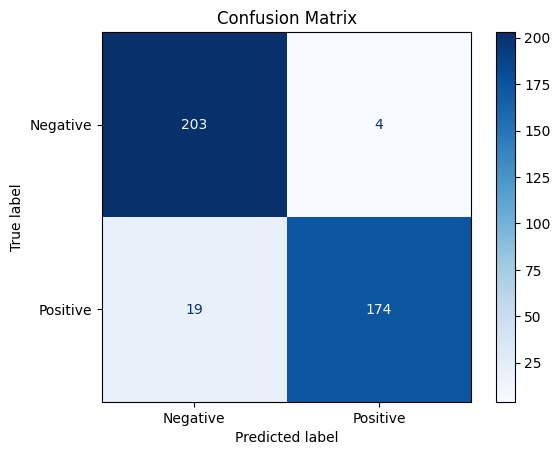

In [5]:
cm = confusion_matrix(y_trues, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                              "Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(output_dir / 'ConfusionMatrix.png')
plt.show()

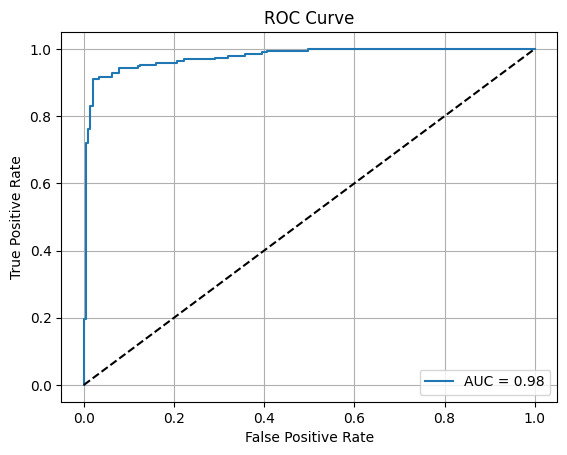

In [6]:
fpr, tpr, _ = roc_curve(y_trues, y_probs)
auc = roc_auc_score(y_trues, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.savefig(output_dir / 'ROCCurve.png')
plt.show()

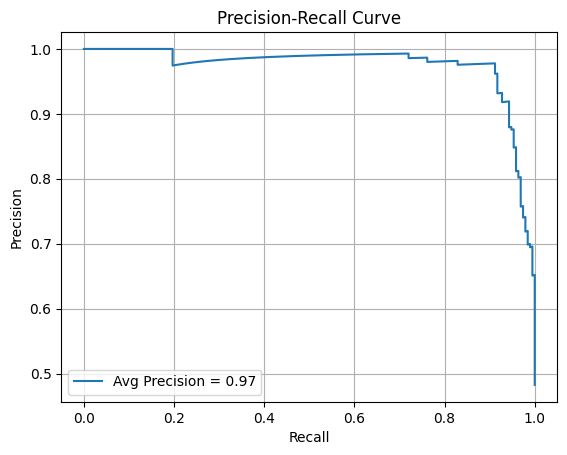

In [7]:
precision, recall, _ = precision_recall_curve(y_trues, y_probs)
ap_score = average_precision_score(y_trues, y_probs)

plt.figure()
plt.plot(recall, precision, label=f"Avg Precision = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.savefig(output_dir / "PRCurve.png")
plt.show()